# FABEMD

In [11]:
import numpy as np
import logging
from scipy.ndimage import maximum_filter, minimum_filter, uniform_filter

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


def get_local_extrema(image, window_size=3):
    """Get local maxima and minima maps for a given image."""
    # logging.info(f"Finding local extrema with window size: {window_size}")
    max_map = image == maximum_filter(image, size=window_size)
    min_map = image == minimum_filter(image, size=window_size)
    return max_map, min_map


def apply_order_statistic_filter(image, extrema_map, filter_type="max", window_size=3):
    """Approximate the envelope using order statistics filters (MAX/MIN)"""
    # logging.info(f"Applying {filter_type} filter with window size: {window_size}")
    if filter_type == "max":
        envelope = maximum_filter(image, size=window_size)
    elif filter_type == "min":
        envelope = minimum_filter(image, size=window_size)
    else:
        raise ValueError("filter_type should be either 'max' or 'min'")
    return np.where(extrema_map, envelope, image)


def smooth_envelope(envelope, smooth_window_size=3):
    """Smooth the envelope with an averaging filter."""
    # logging.info(f"Smoothing envelope with window size: {smooth_window_size}")
    return uniform_filter(envelope, size=smooth_window_size)


def calculate_mean_envelope(upper_envelope, lower_envelope):
    """Calculate the mean envelope."""
    # logging.info("Calculating mean envelope")
    return (upper_envelope + lower_envelope) / 2


def calculate_standard_deviation(FTj, FTj_next):
    """Calculate the standard deviation used for BIMF criteria checking."""
    # logging.info("Calculating standard deviation")
    return np.sqrt(np.sum((FTj_next - FTj) ** 2) / np.sum(FTj**2))


def fabemd(image, max_iterations=10, threshold=0.2, initial_window_size=3):
    """
    Perform FABEMD decomposition on an input image.

    Args:
        image (np.ndarray): Input image (2D array).
        max_iterations (int): Maximum iterations for BIMF extraction.
        threshold (float): Threshold for standard deviation to accept BIMF.
        initial_window_size (int): Initial window size for finding extrema.

    Returns:
        list: A list of extracted BIMFs.
        np.ndarray: Residue of the decomposition.
    """
    logging.info("Starting FABEMD decomposition")
    residual = image.astype(float)
    BIMFs = []

    # Iterate to extract each BIMF
    while True:
        FTj = residual.copy()
        window_size = initial_window_size

        for j in range(max_iterations):
            # logging.info(f"Iteration {j+1}/{max_iterations}")

            # Step 1: Find local maxima and minima
            max_map, min_map = get_local_extrema(FTj, window_size=window_size)

            # Step 2: Estimate upper and lower envelopes using MAX/MIN filters
            upper_envelope = apply_order_statistic_filter(
                FTj, max_map, filter_type="max", window_size=window_size
            )
            lower_envelope = apply_order_statistic_filter(
                FTj, min_map, filter_type="min", window_size=window_size
            )

            # Step 3: Smooth the envelopes
            upper_envelope = smooth_envelope(
                upper_envelope, smooth_window_size=window_size
            )
            lower_envelope = smooth_envelope(
                lower_envelope, smooth_window_size=window_size
            )

            # Step 4: Calculate the mean envelope
            mean_envelope = calculate_mean_envelope(upper_envelope, lower_envelope)

            # Step 5: Update FTj for the next iteration
            FTj_next = FTj - mean_envelope
            SD = calculate_standard_deviation(FTj, FTj_next)

            # Check if the BIMF conditions are met
            if SD < threshold:
                # logging.info(f"BIMF condition met with SD: {SD}")
                BIMFs.append(FTj_next)
                residual -= FTj_next
                break
            else:
                FTj = FTj_next
                window_size += 2  # Optionally adjust window size with each iteration

        # Stop if the residual has fewer than 3 extrema points
        max_map, min_map = get_local_extrema(residual)
        logging.info(f"Residual has {np.sum(max_map)} maxima and {np.sum(min_map)} minima and {len(BIMFs)} BIMFs")
        if np.sum(max_map) + np.sum(min_map) < 3:
            logging.info("Stopping criteria met: fewer than 3 extrema points")
            break

    logging.info("FABEMD decomposition completed")
    return BIMFs, residual


# Usage:
# Assuming `input_image` is the (4096, 3255) grayscale image
# FABEMD decomposition on an example large image
# BIMFs, residue = fabemd(input_image)

In [12]:
import cv2

image_path = "image_sample/1-IMA-01B_Thorax_AP.tiff"

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# describe the image
print("Image shape:", image.shape)

# Resize the image to a smaller size for faster processing
# using 0.1x scaling factor
# image = cv2.resize(image, (0, 0), fx=0.1, fy=0.1)
# resize to 256x256
image = cv2.resize(image, (256, 256))

# describe the resized image
print("Resized image shape:", image.shape)

# Perform FABEMD decomposition
# BIMFs, residue = fabemd(image, max_iterations=10, threshold=1, initial_window_size=3)

Image shape: (4096, 3255)
Resized image shape: (256, 256)


In [13]:
""" 
from https://github.com/kyouma/PyFABEMD/tree/main
 """

import typing

import numpy as np
import scipy


RAM_LIMIT = 1  # split image patches into batches with the batch size limited by this amount of GB


def _find_local_extrema(image, extrema_type: ["max", "min"], extrema_radius):
    if extrema_type == "min":
        image = -image

    # Initialize service variables
    ndims = len(image.shape)
    window_sizes = (2 * extrema_radius + 1,) * ndims
    center_ix = (extrema_radius,) * ndims
    window_axes = tuple(range(-1, -1 - ndims, -1))
    padding_cval = image.min()

    # Search for non-strict extrema with the separable extrema filter, and then check and filter detected points
    extrema_map = image >= scipy.ndimage.maximum_filter(
        image, size=window_sizes, mode="constant", cval=padding_cval
    )
    patches = np.lib.stride_tricks.sliding_window_view(
        np.pad(image, extrema_radius, "constant", constant_values=padding_cval),
        window_sizes,
    )

    ram_limit = int(RAM_LIMIT * 1024**3)

    # Process non-strict local extrema in batches, check for strictness and remove not strict ones
    extrema_ix = np.where(extrema_map)
    extrema_ix = list(zip(*extrema_ix))
    batch_size = max(
        1,
        int(
            np.floor(ram_limit / np.prod(window_sizes, dtype=float) / patches.itemsize)
        ),
    )
    extrema_ix = [
        extrema_ix[i : i + batch_size] for i in range(0, len(extrema_ix), batch_size)
    ]
    extrema_ix = [tuple(map(np.array, zip(*ix))) for ix in extrema_ix]
    for ix in extrema_ix:
        patches_ = patches[ix]  # Here the program may crash by RAM

        windowed_comparison_map = image[ix][(...,) + (np.newaxis,) * ndims] > patches_
        windowed_comparison_map[(...,) + center_ix] = True
        true_map = windowed_comparison_map.all(axis=window_axes)

        extrema_map[tuple(x[~true_map] for x in ix)] = False

    return extrema_map


def fabemd(
    image: np.ndarray,
    max_modes: typing.Optional[int] = None,
    initial_extrema_radius: int = 1,
    smooth_by_which_distance: ["max", "min"] = "min",
    extrema_radius_grows_monotonically: bool = False,
    debug: bool = False,
) -> tuple[np.ndarray, list[int]]:
    """
    Apply Fast and Adaptive Bidimensional Empirical Mode Decomposition [1, 2] algorithm to the image.

    The implementation is based on the description from [3].

    References
    ----------
    [1] S. M. A. Bhuiyan, R. R. Adhami and J. F. Khan, "A novel approach of fast and adaptive bidimensional empirical mode decomposition," 2008 IEEE International Conference on Acoustics, Speech and Signal Processing, Las Vegas, NV, USA, 2008, pp. 1313-1316. https://doi.org/10.1109/ICASSP.2008.4517859.

    [2] Bhuiyan, S.M.A., Adhami, R.R. & Khan, J.F. Fast and Adaptive Bidimensional Empirical Mode Decomposition Using Order-Statistics Filter Based Envelope Estimation. EURASIP J. Adv. Signal Process. 2008, 728356 (2008). https://doi.org/10.1155/2008/728356

    [3] M. U. Ahmed and D. P. Mandic, "Image fusion based on Fast and Adaptive Bidimensional Empirical Mode Decomposition," 2010 13th International Conference on Information Fusion, Edinburgh, UK, 2010, pp. 1-6. https://doi.org/10.1109/ICIF.2010.5711841.

    Parameters
    ----------
    image : np.ndarray
        Input N-dimensional image.
    max_modes : int or None, optional
        Maximum number of intrinsic mode functions (IMFs) to compute, besides the residue. Unlimited if None. The default is None.
    initial_extrema_radius : int, optional
        Initial radius to scan for local extrema. The default is 1.
    smooth_by_which_distance : ['max', 'min'], optional
        Which distance between the nearest extrema to use for smoothing. The default is 'min'.
    extrema_radius_grows_monotonically : bool, optional
        Update the local extrema scan radius with the calculated smoothing window size, or always use the initial radius. The default is False.
    debug : bool, optional
        Print progress report during steps execution. The default is False.

    Returns
    -------
    imfs : np.ndarray
        The array of IMFs and the residue, with the shape (number of IMFs + 1, <input image shape>).
    smoothing_window_sizes : list[int]
        The list of envelope smoothing window sizes for each iteration.
    """
    assert initial_extrema_radius > 0
    assert smooth_by_which_distance in ["max", "min"]

    extrema_radius = initial_extrema_radius

    imfs = []
    smoothing_window_sizes = []

    residue = image
    while max_modes is None or len(imfs) < max_modes:
        if debug:
            print(f"Calculating the {len(imfs)}-th IMF.")
            print(f"    The local extrema search radius is {extrema_radius}.")

        # Find local extrema
        max_map = _find_local_extrema(residue, "max", extrema_radius)
        if debug:
            print(f"    {max_map.sum()} local maxima have been found.")
        min_map = _find_local_extrema(residue, "min", extrema_radius)
        if debug:
            print(f"    {min_map.sum()} local minima have been found.")

        # Check for the stopping criterion
        # if (max_map.sum() < 2) or (min_map.sum() < 2):
        if max_map.sum() + min_map.sum() < 3:
            if debug:
                print("\nFinished.")
            break

        # Calculate the distances between the local extrema
        if debug:
            print("    Calculating the distances between the local extrema... ", end="")
        smoothing_distance = []
        for map_ in [max_map, min_map]:
            coords = np.array(np.where(map_)).T
            if coords.shape[0] > 1:
                distances = scipy.spatial.KDTree(coords).query(coords, k=2, workers=-1)[
                    0
                ][
                    :, -1
                ]  # Without KDTree may crash by RAM
                smoothing_distance.append(
                    distances.max()
                    if smooth_by_which_distance == "max"
                    else distances.min()
                )
            if debug:
                print("Done", end=" and... " if map_ is max_map else "\n")

        smoothing_distance = (
            max(smoothing_distance)
            if smooth_by_which_distance == "max"
            else min(smoothing_distance)
        )
        smoothing_distance = 2 * int(np.ceil(smoothing_distance / 2)) + 1
        smoothing_window_sizes.append(smoothing_distance)
        if debug:
            print(f"    The new smoothing window size is {smoothing_distance}.")

        # We can choose to update the extrema search radius with the calculated smoothing radius
        if extrema_radius_grows_monotonically:
            extrema_radius = smoothing_distance // 2

        # Calculate coarse envolopes
        if debug:
            print("    Calculating the coarse upper envelope... ", end="")
        upper_envelope = scipy.ndimage.maximum_filter(
            residue, smoothing_distance, mode="nearest"
        )
        if debug:
            print("Done")
        if debug:
            print("    Calculating the coarse lower envelope... ", end="")
        lower_envelope = scipy.ndimage.minimum_filter(
            residue, smoothing_distance, mode="nearest"
        )
        if debug:
            print("Done")

        # Calculate smooth envelopes (may have some issues on the border of the image)if debug:
        if debug:
            print("    Smoothing the envelopes... ", end="")
        smooth_envelopes = []
        for envelope in [upper_envelope, lower_envelope]:
            smooth_envelopes.append(
                scipy.ndimage.uniform_filter(
                    envelope, smoothing_distance, mode="nearest"
                )
            )
            if debug:
                print("Done", end=" and... " if envelope is upper_envelope else "\n")

        new_residue = np.mean(smooth_envelopes, axis=0)
        new_imf = residue - new_residue

        imfs.append(new_imf)
        residue = new_residue

        if debug:
            print()

    imfs.append(residue)
    imfs = np.array(imfs)
    return imfs, smoothing_window_sizes

In [14]:
# Perform FABEMD decomposition

imfs, smoothing_window_sizes = fabemd(image, max_modes=None, extrema_radius_grows_monotonically=True, debug=True)
BIMFs = imfs[:-1]
residue = imfs[-1]

# BIMFs, residue = fabemd(image, max_iterations=10, threshold=1, initial_window_size=3)

Calculating the 0-th IMF.
    The local extrema search radius is 1.
    2020 local maxima have been found.
    1954 local minima have been found.
    Calculating the distances between the local extrema... Done and... Done
    The new smoothing window size is 3.
    Calculating the coarse upper envelope... Done
    Calculating the coarse lower envelope... Done
    Smoothing the envelopes... Done and... Done

Calculating the 1-th IMF.
    The local extrema search radius is 1.
    158 local maxima have been found.
    51 local minima have been found.
    Calculating the distances between the local extrema... Done and... Done
    The new smoothing window size is 3.
    Calculating the coarse upper envelope... Done
    Calculating the coarse lower envelope... Done
    Smoothing the envelopes... Done and... Done

Calculating the 2-th IMF.
    The local extrema search radius is 1.
    71 local maxima have been found.
    66 local minima have been found.
    Calculating the distances between t

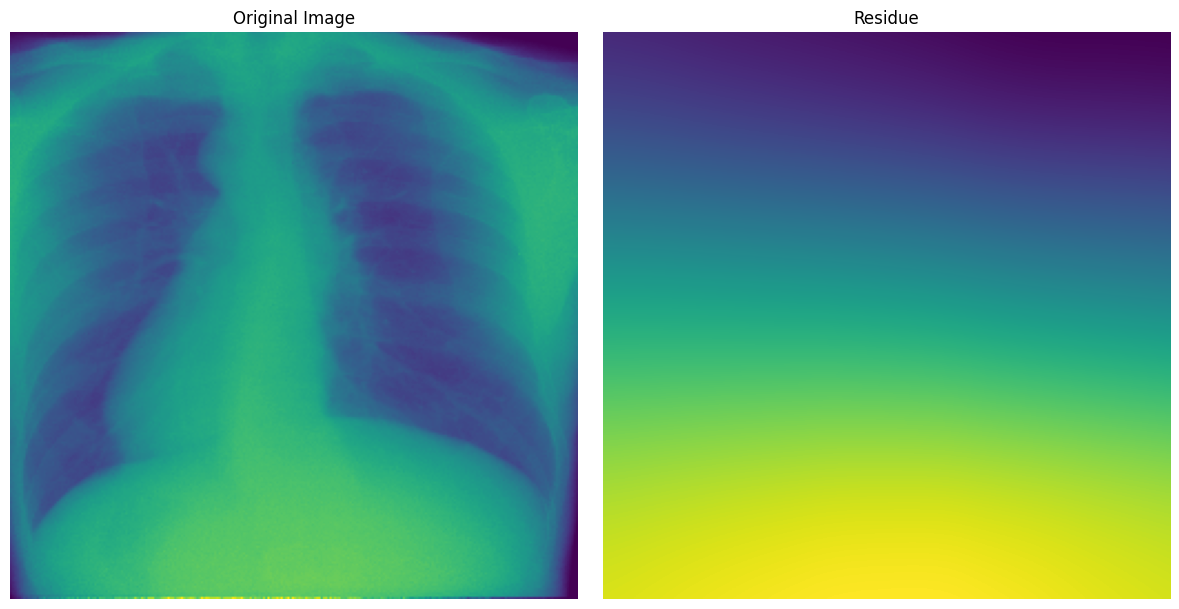

True

In [15]:
# display original image and residue
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(residue)
plt.title("Residue")
plt.axis("off")

plt.tight_layout()
plt.show()

# save the residue image
cv2.imwrite("residue.png", residue)

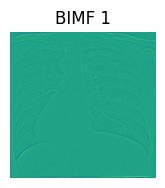

In [16]:
# plot one bimfs
plt.subplot(2, 3, 2)
plt.imshow(BIMFs[0])
plt.title(f"BIMF 1")
plt.axis("off")
plt.show()

# HMF

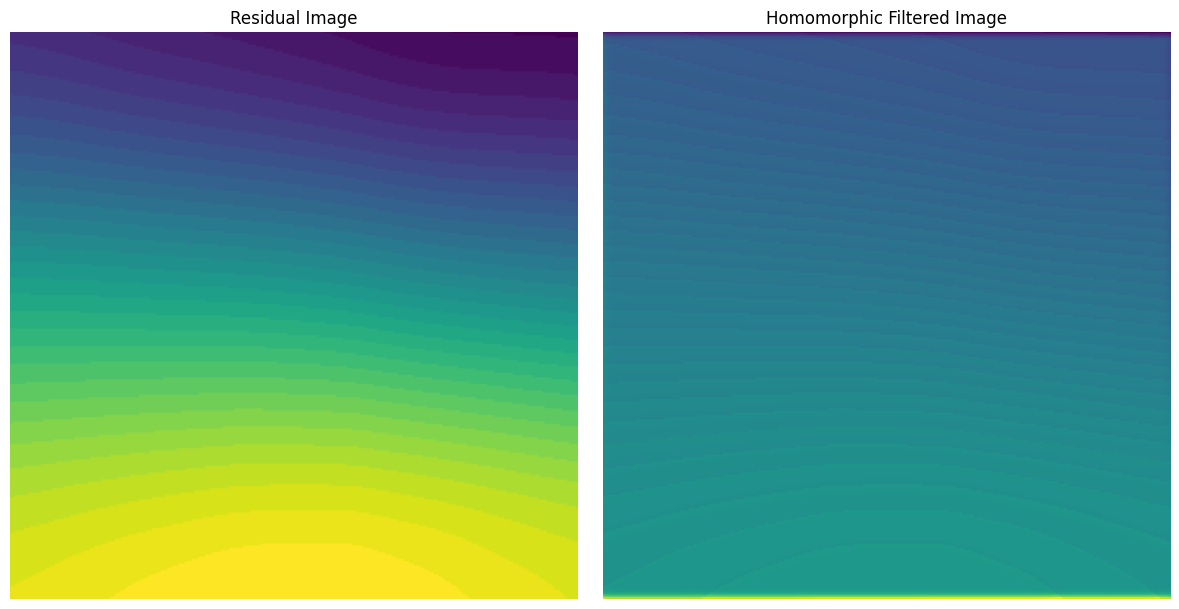

True

In [17]:
import cv2
import numpy as np


def homomorphic_filter(image, d0=30, rh=2.0, rl=0.5, c=1.0):
    # Convert image to float32
    image = np.float32(image)
    rows, cols = image.shape

    # Apply logarithmic transform
    log_image = np.log1p(image)

    # Perform Fourier transform
    dft = cv2.dft(log_image, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Create high-frequency emphasis filter (HEF)
    u = np.arange(rows)
    v = np.arange(cols)
    u, v = np.meshgrid(u - rows / 2, v - cols / 2)
    d = np.sqrt(u**2 + v**2)
    h = (rh - rl) * (1 - np.exp(-c * (d**2 / d0**2))) + rl

    # Apply filter
    h = np.repeat(h[:, :, np.newaxis], 2, axis=2)
    dft_shift_filtered = dft_shift * h

    # Perform inverse Fourier transform
    dft_shift_filtered = np.fft.ifftshift(dft_shift_filtered)
    idft = cv2.idft(dft_shift_filtered)
    idft = cv2.magnitude(idft[:, :, 0], idft[:, :, 1])

    # Normalize the idft result to avoid overflow in expm1
    idft = cv2.normalize(idft, None, 0, 1, cv2.NORM_MINMAX)

    # Apply exponential transform
    exp_image = np.expm1(idft)

    # Handle NaN and Inf values
    exp_image = np.nan_to_num(exp_image, nan=0.0, posinf=255.0, neginf=0.0)

    # Normalize the image to 0-255
    exp_image = cv2.normalize(exp_image, None, 0, 255, cv2.NORM_MINMAX)
    exp_image = np.uint8(exp_image)

    return exp_image


# Load the residual image
residual_image = cv2.imread("residue.png", cv2.IMREAD_GRAYSCALE)

# Load the residue image
# residual_image = residue

# Apply homomorphic filter with HEF
filtered_image = homomorphic_filter(residual_image)

# Display the results using plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(residual_image)
plt.title("Residual Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(filtered_image)
plt.title("Homomorphic Filtered Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the filtered image
cv2.imwrite("filtered_image.png", filtered_image)

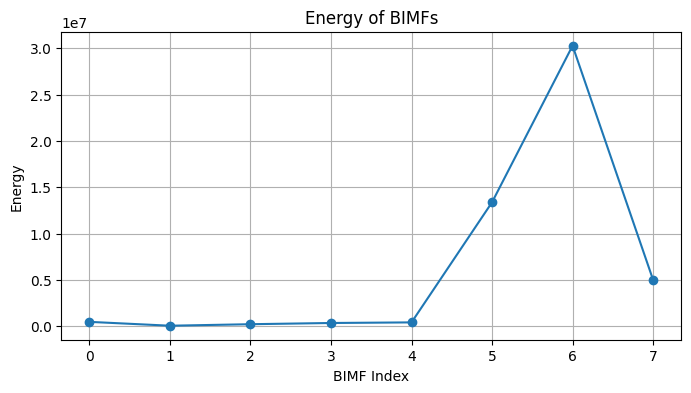

In [18]:
import numpy as np


def calculate_bimf_energy(bimfs):
    """
    Calculate the energy of each BIMF.

    Parameters:
    bimfs (list of np.ndarray): List of BIMF components.

    Returns:
    list of float: Energies of each BIMF.
    """
    energies = []
    for bimf in bimfs:
        energy = np.sum(np.square(bimf))
        energies.append(energy)
    return energies


# Contoh penggunaan
# Misalkan kita memiliki daftar BIMF yang telah diekstraksi dari gambar
# bimfs = [bimf1, bimf2, bimf3]  # Gantilah dengan BIMF yang sebenarnya

# Hitung energi dari setiap BIMF
energies = calculate_bimf_energy(BIMFs)

# Tampilkan energi dari setiap BIMF
# for i, energy in enumerate(energies):
#     print(f"Energy of BIMF {i+1}: {energy}")

# Plot the energy of each BIMF
plt.figure(figsize=(8, 4))
plt.plot(energies, marker="o")
plt.xlabel("BIMF Index")
plt.ylabel("Energy")
plt.title("Energy of BIMFs")
plt.grid(True)
plt.show()

# NonLinear Filtering

True

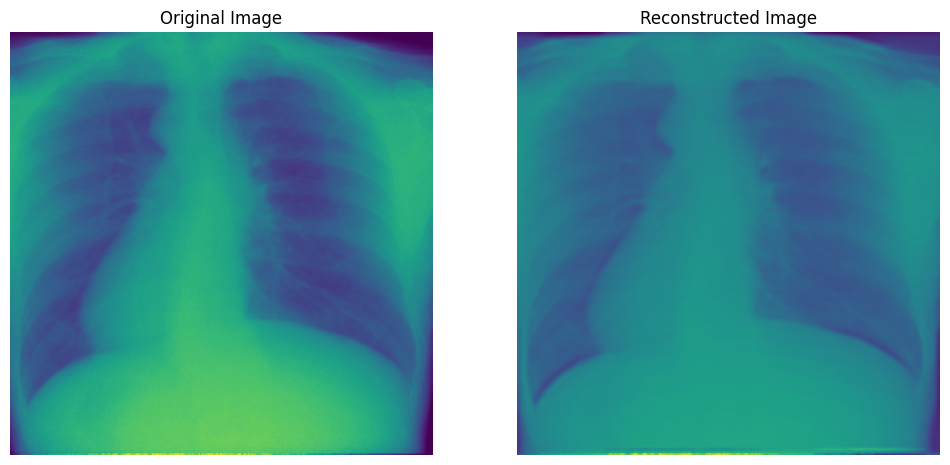

In [19]:
def nl_means_filtering(bimf, h=10, templateWindowSize=7, searchWindowSize=21):
    # Check if BIMF is already in 8-bit unsigned integer format
    if bimf.dtype != np.uint8:
        # Convert BIMF to 8-bit unsigned integer
        bimf = cv2.normalize(bimf, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Apply NL-means filter
    return cv2.fastNlMeansDenoising(bimf, None, h, templateWindowSize, searchWindowSize)


def reconstruct_image(bimfs, energies, R, beta, filtered_residual):
    # Sort BIMFs based on energy
    sorted_indices = np.argsort(energies)

    # Denoise R components with the lowest energy
    denoised_bimfs = []
    for i in range(R):
        index = sorted_indices[i]
        denoised_bimfs.append(nl_means_filtering(bimfs[index]))

    # Combine denoised BIMFs and original BIMFs
    I_E = np.sum(denoised_bimfs, axis=0).astype(np.float64)
    for j in range(R, len(bimfs)):
        index = sorted_indices[j]
        I_E += bimfs[index].astype(np.float64)

    # Reconstruct the image by adding the filtered residual
    I_L = I_E + beta * filtered_residual.astype(np.float64)
    return I_L


# Tentukan jumlah komponen energi terendah yang akan didenoise
R = 1  # Misalkan kita memilih 1 komponen energi terendah

# Tentukan parameter beta
beta = 0.5  # Misalkan kita memilih nilai beta 0.5

# Rekonstruksi gambar
reconstructed_image = reconstruct_image(BIMFs, energies, R, beta, filtered_image)

# Tampilkan gambar hasil rekonstruksi and compare with the original image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis("off")


# Save the reconstructed image
cv2.imwrite("reconstructed_image.png", reconstructed_image)

# Gamma correction

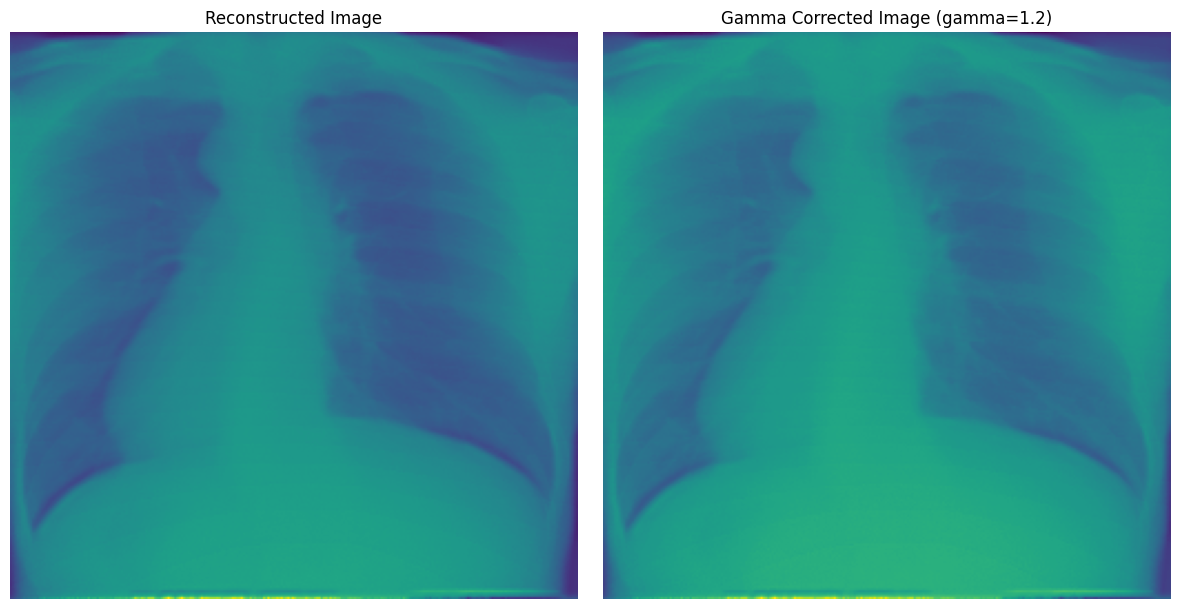

True

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def gamma_correction(image, gamma):
    # Build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    inv_gamma = 1.0 / gamma
    table = np.array(
        [((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]
    ).astype("uint8")

    # Ensure the image is in 8-bit format
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)


# Example usage
# Assume we have the reconstructed image
# reconstructed_image = cv2.imread("reconstructed_image.png", cv2.IMREAD_GRAYSCALE)

# Apply gamma correction with gamma value 1.2
gamma = 1.2  # Example gamma value
gamma_corrected_image = gamma_correction(reconstructed_image, gamma)

# Display the gamma corrected image and compare with reconstructed image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gamma_corrected_image)
plt.title(f"Gamma Corrected Image (gamma={gamma})")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the gamma corrected image
cv2.imwrite("gamma_corrected_image.png", gamma_corrected_image)

# CLAHE

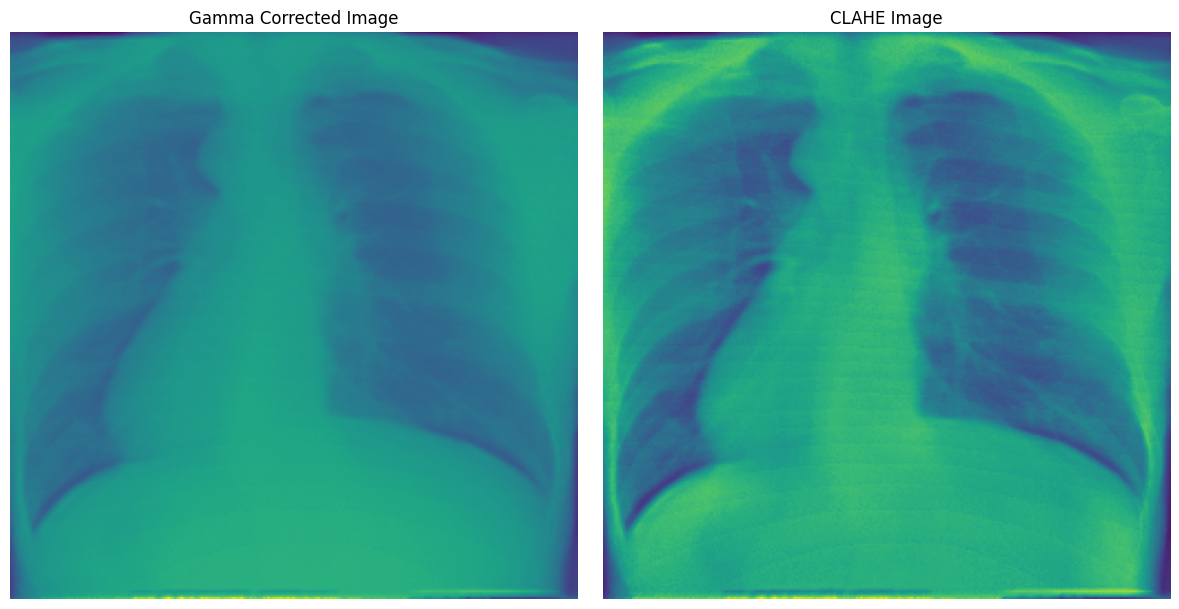

True

In [21]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Apply CLAHE to the image
    return clahe.apply(image)

clahe_image = apply_clahe(gamma_corrected_image)

# Display the CLAHE image and compare with the gamma corrected image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gamma_corrected_image)
plt.title("Gamma Corrected Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clahe_image)
plt.title("CLAHE Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the CLAHE image
cv2.imwrite("clahe_image.png", clahe_image)

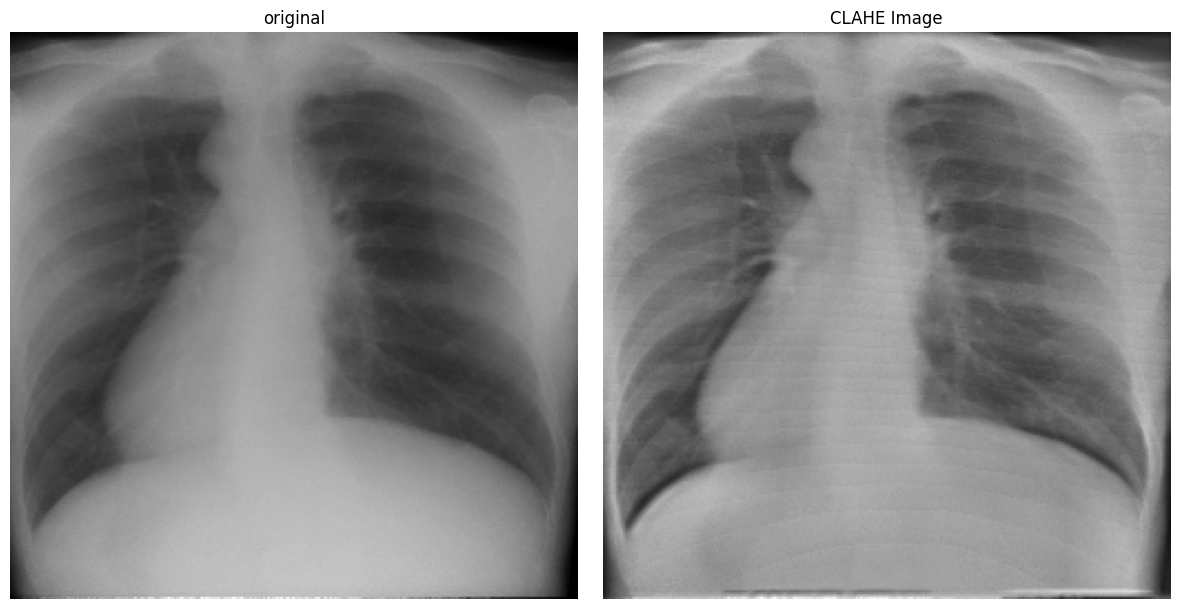

In [22]:
# compare clahe and original
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clahe_image, cmap="gray")
plt.title("CLAHE Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Metrics

In [23]:
import numpy as np
import cv2


def calculate_contrast(image, mask):
    """
    Calculate the contrast of a region in the image defined by the mask.

    Parameters:
    image (np.ndarray): Grayscale image.
    mask (np.ndarray): Binary mask defining the region of interest.

    Returns:
    float: Contrast value.
    """
    foreground = image[mask == 1]
    background = image[mask == 0]

    # print("fore", foreground)
    # print("back", background)

    # if len(foreground) == 0 or len(background) == 0:
    #     return 0.0  # Return 0 contrast if there are no valid pixels

    X_f = np.mean(foreground)
    X_b = np.mean(background)

    if len(background) == 0:
        X_b = 0

    if X_f + X_b == 0:
        return 0.0  # Avoid division by zero

    contrast = (X_f - X_b) / (X_f + X_b)
    return contrast


def calculate_cii(processed_image, reference_image, mask):
    """
    Calculate the Contrast Improvement Index (CII).

    Parameters:
    processed_image (np.ndarray): Processed grayscale image.
    reference_image (np.ndarray): Reference (original) grayscale image.
    mask (np.ndarray): Binary mask defining the region of interest.

    Returns:
    float: CII value.
    """
    C_processed = calculate_contrast(processed_image, mask)
    C_reference = calculate_contrast(reference_image, mask)

    # print(C_processed)
    # print(C_reference)

    CII = C_processed / C_reference
    return CII

def calculate_entropy(image):
    """
    Calculate the entropy of an image.

    Parameters:
    image (np.ndarray): Grayscale image.

    Returns:
    float: Entropy value.
    """
    # Hitung histogram gambar
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Normalisasi histogram sehingga jumlahnya menjadi 1
    hist = hist / hist.sum()

    # Hitung entropy
    entropy = -np.sum(
        hist * np.log(hist + 1e-7)
    )  # Tambahkan 1e-7 untuk menghindari log(0)

    return entropy


def calculate_eme(image, r, c, epsilon=0.0001):
    """
    Calculate the Effective Measure of Enhancement (EME) of an image.

    Parameters:
    image (np.ndarray): Grayscale image.
    r (int): Number of rows to split the image into.
    c (int): Number of columns to split the image into.
    epsilon (float): Small constant to avoid division by zero.

    Returns:
    float: EME value.
    """
    height, width = image.shape
    block_height = height // r
    block_width = width // c

    eme = 0.0
    for i in range(r):
        for j in range(c):
            # Extract the block
            block = image[
                i * block_height : (i + 1) * block_height,
                j * block_width : (j + 1) * block_width,
            ]

            # Calculate the maximum and minimum intensity levels in the block
            I_max = np.max(block)
            I_min = np.min(block)

            if I_min + epsilon == 0:
                continue  # Skip this block to avoid division by zero

            # Calculate the contrast ratio for the block
            CR = I_max / (I_min + epsilon)

            # Update the EME value
            eme += 20 * np.log(CR)

    # Normalize the EME value by the number of blocks
    eme /= r * c

    return eme


# # Contoh penggunaan
# # Misalkan kita memiliki gambar yang diproses
# processed_image = cv2.imread("processed_image.png", cv2.IMREAD_GRAYSCALE)

# # Hitung EME dengan membagi gambar menjadi 4x4 blok
# r, c = 4, 4
# eme = calculate_eme(processed_image, r, c)

# # Tampilkan hasil
# print("Effective Measure of Enhancement (EME):", eme)

# loop

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Fungsi untuk menampilkan histogram
def show_histogram(image, title="Histogram"):
    """
    Display the histogram of a grayscale image.

    Parameters:
    image (np.ndarray): Grayscale image.
    title (str): Title of the histogram plot.
    """
    # Hitung histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.plot(hist, color="black")
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim([0, 256])
    plt.grid(True)
    plt.show()


# Contoh penggunaan
# Misalkan kita memiliki gambar referensi

# Tampilkan histogram dari gambar referensi
# show_histogram(image, title="Histogram of Reference Image")

Total parameter combinations: 432


d:\OneDrive-UGM-from\x-ray\scaling\.conda\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\OneDrive-UGM-from\x-ray\scaling\.conda\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


params (20, 1.5, 0.3, 1.0, 3.0, (16, 16)), score 49.243593186799124, cii 1.0, ent 4.946670055389404, eme 43.29692313140972
params (20, 1.5, 0.3, 0.8, 3.0, (8, 8)), score 60.696140229754356, cii 1.0, ent 4.991894721984863, eme 54.70424550776949
params (20, 1.5, 0.3, 0.8, 3.0, (16, 16)), score 54.24140163603273, cii 1.0, ent 4.937371253967285, eme 48.30403038206544
params (20, 1.5, 0.3, 1.0, 3.0, (8, 8)), score 54.03851914063352, cii 1.0, ent 4.9879255294799805, eme 48.05059361115354
params (20, 1.5, 0.3, 0.8, 2.0, (8, 8)), score 56.612739062345845, cii 1.0, ent 4.865924835205078, eme 50.74681422714077
params (20, 1.5, 0.3, 1.0, 2.0, (16, 16)), score 44.33170733410627, cii 1.0, ent 4.837881088256836, eme 38.493826245849434
params (20, 1.5, 0.3, 1.0, 2.0, (8, 8)), score 49.98385011523963, cii 1.0, ent 4.873530387878418, eme 44.110319727361215
params (20, 1.5, 0.3, 1.2, 2.0, (8, 8)), score 45.498186039865864, cii 1.0, ent 4.856178283691406, eme 39.64200775617446
params (20, 1.5, 0.3, 0.8, 

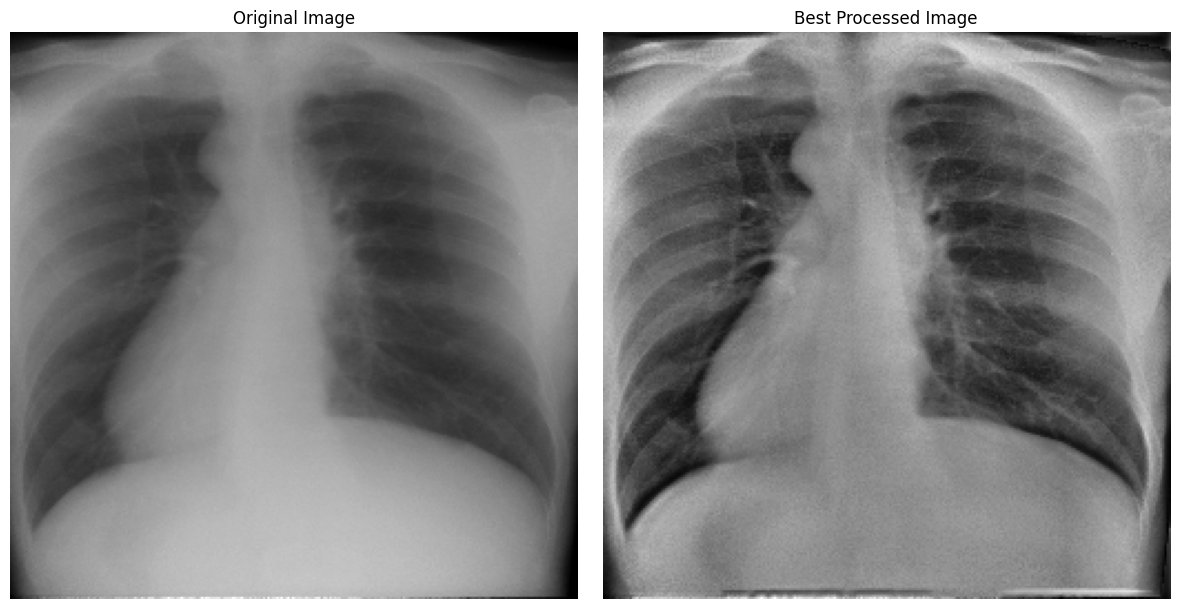

Best Parameters:
d0: 30
rh: 2.0
rl: 0.3
gamma: 0.8
clip_limit: 3.0
tile_grid_size: (8, 8)


True

In [25]:
import cv2
import itertools
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define the functions (assuming they are defined elsewhere in the notebook)
# def homomorphic_filter(image, d0=30, rh=2.0, rl=0.5, c=1.0):
# def calculate_bimf_energy(bimfs):
# def reconstruct_image(bimfs, energies, R, beta, filtered_residual):
# def gamma_correction(image, gamma):
# def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
# def calculate_cii(image, reference_image, mask):
# def calculate_entropy(image):
# def calculate_eme(image, r, c):

# Define parameter ranges
d0_values = [20, 30, 40]
rh_values = [1.5, 2.0, 2.5]
rl_values = [0.3, 0.5, 0.7]
gamma_values = [0.8, 1.0, 1.2, 1.4]
clip_limit_values = [2.0, 3.0]
tile_grid_size_values = [(8, 8), (16, 16)]

# Generate parameter combinations
parameter_combinations = list(
    itertools.product(
        d0_values,
        rh_values,
        rl_values,
        gamma_values,
        clip_limit_values,
        tile_grid_size_values,
    )
)

print("Total parameter combinations:", len(parameter_combinations))

# Initialize variables to store evaluation results
best_cii = 0.0
best_entropy = 0.0
best_emr = 0.0
best_parameters = None
best_image = None

# Load the reference image
# reference_image = cv2.imread("image_sample/1-IMA-01B_Thorax_AP.tiff", cv2.IMREAD_GRAYSCALE)
reference_image = image

def process_parameters(params):
    d0, rh, rl, gamma, clip_limit, tile_grid_size = params

    # Apply homomorphic filter
    filtered_image = homomorphic_filter(reference_image, d0=d0, rh=rh, rl=rl)

    # Determine the number of BIMFs to denoise
    R = 1

    # Determine the beta value
    beta = 0.5

    # Reconstruct the image
    reconstructed_image = reconstruct_image(BIMFs, energies, R, beta, filtered_image)

    # Apply gamma correction
    gamma_corrected_image = gamma_correction(reconstructed_image, gamma=gamma)

    # Apply CLAHE
    clahe_image = apply_clahe(gamma_corrected_image, clip_limit=clip_limit, tile_grid_size=tile_grid_size)

    # Calculate CII
    mask = np.ones_like(reference_image)
    cii = calculate_cii(clahe_image, reference_image, mask)

    # Calculate entropy
    entropy = calculate_entropy(clahe_image)

    # Calculate EME
    r, c = 4, 4
    eme = calculate_eme(clahe_image, r, c)

    evaluation_result = cii + entropy + eme
    return evaluation_result, cii, entropy, eme, params, clahe_image

# Use ThreadPoolExecutor to process parameter combinations concurrently
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_parameters, params) for params in parameter_combinations]

    for future in as_completed(futures):
        evaluation_result, cii, entropy, eme, params, clahe_image = future.result()
        print(f"params {params}, score {evaluation_result}, cii {cii}, ent {entropy}, eme {eme}")
        if evaluation_result > best_cii + best_entropy + best_emr:
            best_cii = cii
            best_entropy = entropy
            best_emr = eme
            best_parameters = params
            best_image = clahe_image

# Compare best result image with reference image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(best_image, cmap='gray')
plt.title("Best Processed Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Show best parameters
print("Best Parameters:")
print(f"d0: {best_parameters[0]}")
print(f"rh: {best_parameters[1]}")
print(f"rl: {best_parameters[2]}")
print(f"gamma: {best_parameters[3]}")
print(f"clip_limit: {best_parameters[4]}")
print(f"tile_grid_size: {best_parameters[5]}")

# Save best image
cv2.imwrite("best_processed_image.png", best_image)

In [26]:
print("Best Score:")
print(f"CII: {best_cii}")
print(f"Entropy: {best_entropy}")
print(f"EME: {best_emr}")

Best Score:
CII: 1.0
Entropy: 4.996280670166016
EME: 66.29781950172422


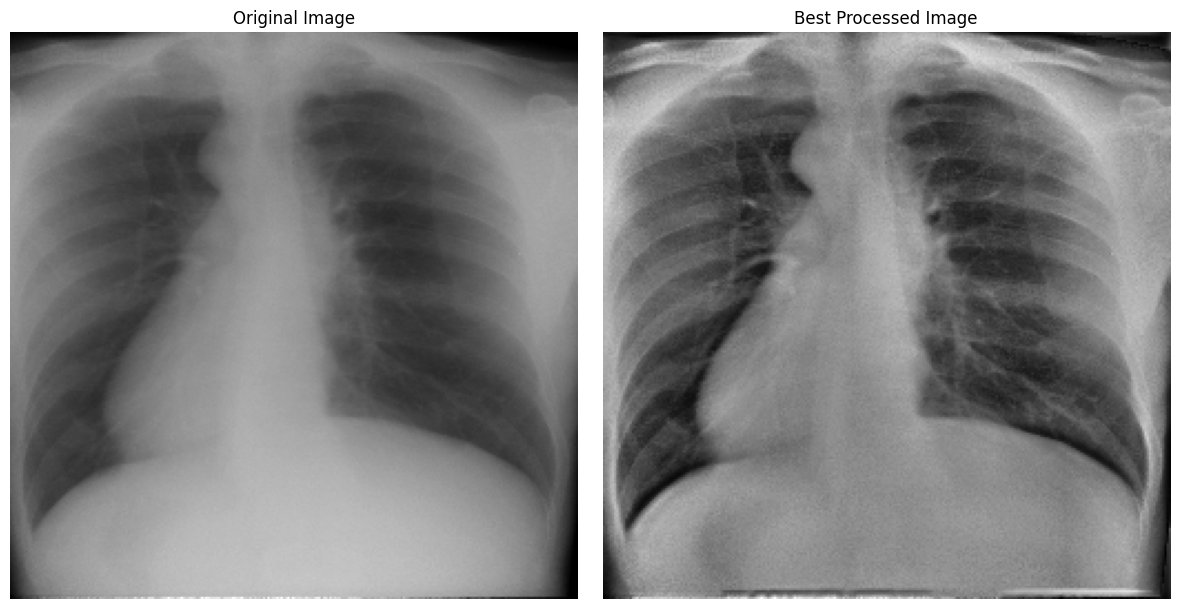

In [27]:
# compare best result image with reference image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(best_image, cmap="gray")
plt.title("Best Processed Image")
plt.axis("off")

plt.tight_layout()
plt.show()